# Dynamics Analysis (Symbolic)

@[Chaoming Wang](https://github.com/chaoming0625)

As is known to us all, dynamics analysis is necessary in neurodynamics. This is because blind simulation of nonlinear systems is likely to produce few results or misleading results. For example, attractors and repellors can be easily obtained through simulation by time forward and backward, while saddles can be hard to find. 

Currently, BrainPy supports two kinds of analysis methods (see [brainpy.analyis documents](../apis/analysis.rst)): 

- Dynamics analysis with symbolic inference
- [Continuation analysis](https://en.wikipedia.org/wiki/Numerical_continuation)

The first class of analysis method supports neurodynamics analysis for low-dimensional dynamical systems. Specifically, BrainPy provides the following methods for dynamics analysis:

1. phase plane analysis for one-dimensional and two-dimensional systems;
2. codimension one and codimension two bifurcation analysis;
3. bifurcation analysis of the fast-slow system. 

In this section, I will illustrate how to do neuron dynamics analysis in BrainPy and how BrainPy implements it.

In [1]:
import brainpy as bp

bp.__version__

'1.1.0'

## Phase Plane Analysis


We provide a fundamental class ``PhasePlane`` to help users make
phase plane analysis for 1D/2D dynamical systems. Five methods
are provided, which can help you to plot:

- Fixed points
- Nullcline (zero-growth isoclines)
- Vector filed
- Limit cycles
- Trajectory

Here, I will illustrate how to do phase plane analysis by using a well-known neuron model FitzHugh-Nagumo model.

**FitzHugh-Nagumo model**

The FitzHugh-Nagumo model is given by:

$$ 
\frac {dV} {dt} = V(1 - \frac {V^2} 3) - w + I_{ext} \\
\tau \frac {dw} {dt} = V + a - b w 
$$

There are two variables $V$ and $w$, so this is a two-dimensional system with three parameters $a, b$ and $\tau$.

In [2]:
a = 0.7
b = 0.8
tau = 12.5
Vth = 1.9


@bp.odeint
def int_fhn(V, w, t, Iext):
  dw = (V + a - b * w) / tau
  dV = V - V * V * V / 3 - w + Iext
  return dV, dw

Phase Plane Analysis is implemented in `brainpy.sym_analysis.PhasePlane`. It receives the following parameters: 

- ``integrals``: The integral functions or instance of ``brainpy.DynamicalSystem`` are going to be analyzed. 
- ``target_vars``: The variables to be analuzed. It must a dictionary with the format of `{var: variable range}`.
- ``fixed_vars``: The variables to be fixed (optional).
- ``pars_update``: Parameters to update (optional).

`brainpy.analysis.PhasePlane` provides interface to analyze the system's 

- **nullcline**: The zero-growth isoclines, such as $g(x, y)=0$ and $g(x, y)=0$.
- **fixed points**: The equilibrium points of the system, which are located at all of the nullclines intersect.
- **vector filed**: The vector field of the system.
- **Trajectory**: A given simulation trajectory with the fixed variables.
- **Limit cycles**: The limit cycles.

Here we perform a phase plane analysis with parameters $a=0.7, b=0.8, \tau=12.5$, and input $I_{ext} = 0.8$.

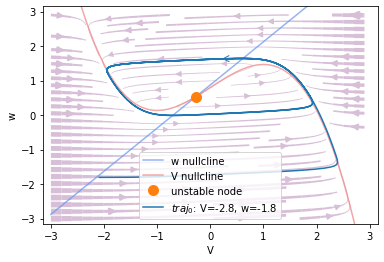

In [3]:
analyzer = bp.symbolic.PhasePlane(
  int_fhn,
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  pars_update={'Iext': 0.8})
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory([{'V': -2.8, 'w': -1.8}],
                         duration=100.,
                         show=True)

We can see an unstable-node at the point (v=-0.27, w=0.53) inside a limit cycle. Then we can run a simulation with the same parameters and initial values to see the periodic activity that correspond to the limit cycle.

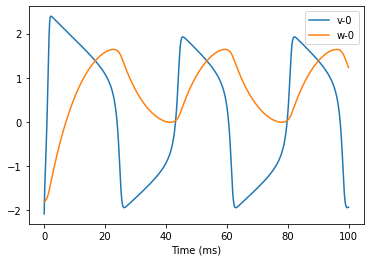

In [5]:
class FHN(bp.NeuGroup):
  def __init__(self, num, **kwargs):
    super(FHN, self).__init__(size=num, **kwargs)
    self.V = bp.math.Variable(bp.math.ones(num) * -2.8)
    self.w = bp.math.Variable(bp.math.ones(num) * -1.8)
    self.Iext = bp.math.Variable(bp.math.zeros(num))

  def update(self, _t, _dt):
    self.V[:], self.w[:] = int_fhn(self.V, self.w, _t, self.Iext)
    self.Iext[:] = 0.


group = FHN(1, monitors=['V', 'w'])
group.run(100., inputs=('Iext', 0.8))
bp.visualize.line_plot(group.mon.ts, group.mon.V, legend='v', )
bp.visualize.line_plot(group.mon.ts, group.mon.w, legend='w', show=True)

Note that the `fixed_vars` can be used to specify the neuron model's state `ST`, it can also be used to specify the functional arguments in integrators (like the `Iext` in `int_v()`). 

## Bifurcation Analysis

Bifurcation analysis is implemented within `brainpy.sym_analysis.Bifurcation`. Which support codimension-1 and codimension-2 bifurcation analysis. Specifically, it receives the following parameter settings: 

- ``integrals``: The integral functions or instance of ``brainpy.DynamicalSystem`` are going to be analyzed.
- ``target_pars``: The target parameters. Must be a dictionary with the format of `{par: parameter range}`. 
- ``target_vars``: The target variables. Must be a dictionary with the format of `{var: variable range}`. 
- ``fixed_vars``: The fixed variables.
- ``pars_update``: The parameters to update.

**Codimension 1 bifurcation analysis**

We will first see the codimension 1 bifurcation anlysis of the model. For example, we vary the input $I_{ext}$ between 0 to 1 and see how the system change it's stability.

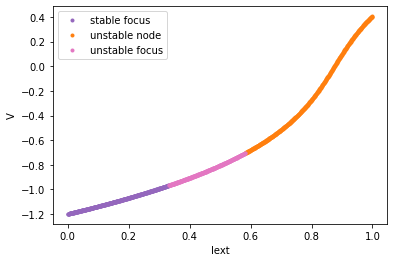

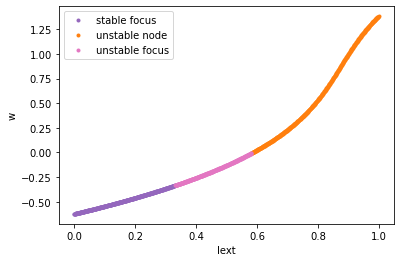

In [7]:
analyzer = bp.symbolic.Bifurcation(
  int_fhn,
  target_pars={'Iext': [0., 1.]},
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  numerical_resolution=0.001,
)
res = analyzer.plot_bifurcation(show=True)

**Codimension 2 bifurcation analysis**

We simulaneously change $I_{ext}$ and parameter $a$.

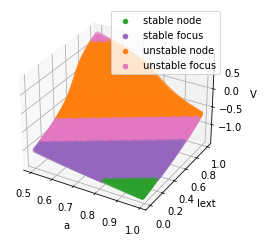

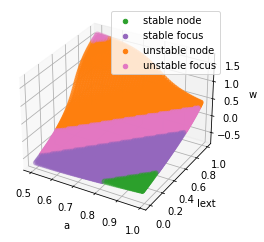

In [10]:
analyzer = bp.symbolic.Bifurcation(
  int_fhn,
  target_pars=dict(a=[0.5, 1.], Iext=[0., 1.]),
  target_vars=dict(V=[-3, 3], w=[-3., 3.]),
  numerical_resolution=0.01,
)
res = analyzer.plot_bifurcation(show=True)

## Fast-Slow System Bifurcation

BrainPy also provides a tool for fast-slow system bifurcation analysis by using `brainpy.sym_analysis.FastSlowBifurcation`. This method is proposed by John Rinzel [1, 2, 3]. (J Rinzel, 1985, 1986, 1987) proposed that in a fast-slow dynamical system, we can treat the slow variables as the bifurcation parameters, and then study how the different value of slow variables affect the bifurcation of the fast sub-system.


`brainpy.sym_analysis.FastSlowBifurcation` is very usefull in the bursting neuron analysis. I will illustrate this by using the Hindmarsh-Rose model. The Hindmarsh–Rose model of neuronal activity is aimed to study the spiking-bursting behavior of the membrane potential observed in experiments made with a single neuron. Its dynamics are governed by:

$$
\begin{aligned}
\frac{d V}{d t} &= y - a V^3 + b V^2 - z + I\\
\frac{d y}{d t} &= c - d V^2 - y\\
\frac{d z}{d t} &= r (s (V - V_{rest}) - z)
\end{aligned}
$$

First of all, let's define the Hindmarsh–Rose model with BrainPy. 

In [11]:
a = 1.
b = 3.
c = 1.
d = 5.
s = 4.
x_r = -1.6
r = 0.001
Vth = 1.9


@bp.odeint(method='rk4', dt=0.02)
def int_hr(x, y, z, t, Isyn):
  dx = y - a * x ** 3 + b * x * x - z + Isyn
  dy = c - d * x * x - y
  dz = r * (s * (x - x_r) - z)
  return dx, dy, dz

We now can start to analysis the underlying bifurcation mechanism.

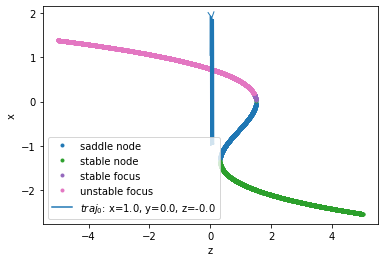

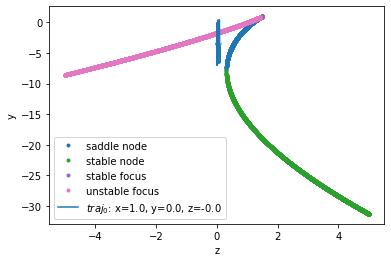

In [12]:
analyzer = bp.symbolic.FastSlowBifurcation(
  int_hr,
  fast_vars={'x': [-3, 3], 'y': [-10., 5.]},
  slow_vars={'z': [-5., 5.]},
  pars_update={'Isyn': 0.5},
  numerical_resolution=0.001
)
analyzer.plot_bifurcation()
analyzer.plot_trajectory([{'x': 1., 'y': 0., 'z': -0.0}],
                         duration=100.,
                         show=True)

**References**:

[1] Rinzel, John. "Bursting oscillations in an excitable membrane model." In Ordinary and partial differential  equations, pp. 304-316. Springer, Berlin, Heidelberg, 1985.
           
[2] Rinzel, John , and Y. S. Lee . On Different Mechanisms for Membrane Potential Bursting. Nonlinear Oscillations in Biology and Chemistry. Springer Berlin Heidelberg, 1986.

[3] Rinzel, John. "A formal classification of bursting mechanisms in excitable systems." In Mathematical topics in population biology, morphogenesis and neurosciences, pp. 267-281. Springer, Berlin, Heidelberg, 1987.
